# install requirements (if necessary)

!pip install tensorflow==2.8.4

# Prepare Datasets

### The original StableDiffusion was trained on LAION 5b which is about 80TB. However, it is to large for a personal computer, such that this notebook chose to use a smaller dataset https://www.kaggle.com/datasets/vitaliykinakh/stable-imagenet1k/data

<span style="color:red; font-size:20pt; font-family:Times New Roman">
Run the preprocess codes in this repository before running the rest cells after downloading data.

# Add noise on Images

In [1]:
import os

In [ ]:
noiseFiles = os.listdir("./data/fairyTails/")
noiseFiles

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

In [ ]:
img = image.imread("./data/fairyTails/0.jpg")
plt.imshow(img)
# create noise array by normal random 生成正态随机数作为噪声点 ques:生成的随机数有正有负，为什么不用取绝对值？如果不取绝对值叠加上原图是否可能出现负数？
noises = np.random.normal(size=(256,256,3),)
noises

In [ ]:
# normalize img to 0~1 将图像矩阵归一化到 0~1
img = np.array(img)/255.0
img

In [6]:
# generate noise_power 随机生成噪声强度
noise_power = np.random.uniform(size=(1,1,1))
noise_power

array([[[0.41772667]]])

In [7]:
# calculate signal_power 计算原信号强度
signal_power = 1.0 - noise_power
signal_power

array([[[0.58227333]]])

In [8]:
# calculate noise_rates and signal_rates 计算信号和噪声占比
noise_rates = noise_power ** 0.5
signal_rates = signal_power ** 0.5
signal_rates

array([[[0.76306837]]])

In [9]:
# calculate the images with noise 计算加噪后的图片
noisy_images = signal_rates * img + noise_rates * noises
noisy_images

array([[[ 0.19806526, -0.25800373,  0.83374905],
        [-0.77088428,  1.80774353,  1.00865265],
        [-0.49424533,  0.02946344,  1.72055963],
        ...,
        [-0.40291357,  0.44327565,  0.50337745],
        [ 0.51898094, -0.26335961,  1.43466876],
        [ 1.03463563,  0.45479772, -0.02650595]],

       [[ 1.21813843,  2.15488698,  0.4712497 ],
        [ 0.68922178, -0.3361576 ,  0.78597257],
        [ 0.09029363,  0.50419734,  0.7001314 ],
        ...,
        [ 0.23967834,  0.51307741,  1.7507971 ],
        [ 1.02415899,  0.25891072, -0.11150109],
        [ 1.08993146,  1.49105955,  0.59575722]],

       [[ 0.35586181,  1.71324313,  0.23710036],
        [-0.35666979, -0.37150312,  0.83690126],
        [ 1.65639712,  0.87477406,  0.22173484],
        ...,
        [ 0.83461394,  0.01199015,  0.31689487],
        [ 1.210821  ,  1.96167704,  0.86536765],
        [ 0.7933225 ,  0.83006127, -0.13928779]],

       ...,

       [[ 0.72536563,  0.72505395,  0.38595946],
        [ 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


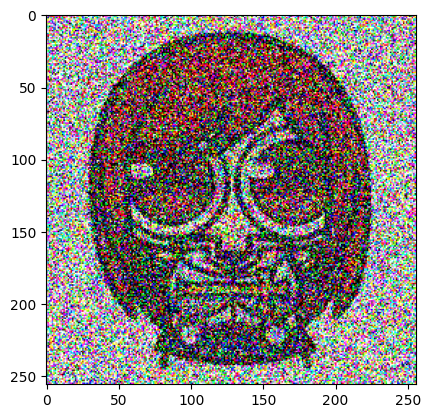

In [10]:
# show the images with noise 展示加噪后的图片
plt.imshow(noisy_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


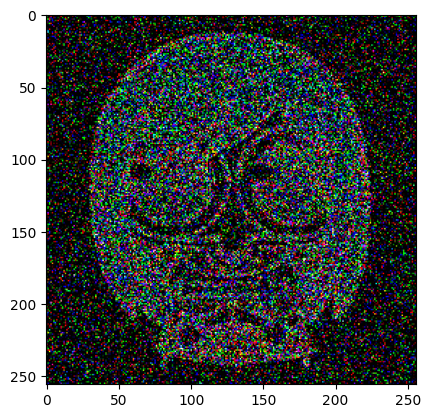

In [12]:
velocities = -noise_rates * img + signal_rates * noises
plt.imshow(velocities)

# CLIP Encoder

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate

## Embedding

### TokenEmbedding

In [14]:
class TokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_tokens=10000, output_sequence_length=256, word_dims=256):
        super(TokenEmbedding, self).__init__()
        self.Divide = tf.keras.layers.TextVectorization(max_tokens=max_tokens,output_sequence_length=output_sequence_length)
        self.Divide.adapt(train_text)
        self.Embed = tf.keras.layers.Embedding(max_tokens, word_dims, name='word_embedding')
    def call(self, inputs, **kwargs):
        x = inputs
        x = self.Divide(x)
        x = self.Embed(x)
        
        return x

### PositionEmbedding

In [15]:
class PositionEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, output_sequence_length=256, word_dims=256):
        super(PositionEmbeddingLayer, self).__init__()
        self.pos_embedding = self.add_weight(
            "pos_embedding", shape=[output_sequence_length, word_dims])
        self.seq_len = output_sequence_length
    def call(self, x):
        batch_size, output = tf.shape(x)[0], tf.shape(x)[1]
        
        return self.pos_embedding[tf.newaxis, :self.seq_len, :]

### FinalEmbedding

In [16]:
class FinalEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_tokens=10000, output_sequence_length=256, word_dims=256):
        super(FinalEmbedding, self).__init__()
        self.Token = TokenEmbedding(max_tokens=max_tokens, output_sequence_length=output_sequence_length, word_dims=word_dims)
        self.Position = PositionEmbeddingLayer(output_sequence_length=output_sequence_length, word_dims=word_dims)
    def call(self, inputs):
        x = self.Token(inputs)
        y = self.Position(inputs)

        return x + y

## CLIPEncoderLayer

In [17]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, d_model=256, num_heads=8, dropout_rate=0.1):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads, dropout=dropout_rate)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [18]:
class SelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [19]:
class MLP(tf.keras.layers.Layer):
    def __init__(self, d_model=256, dff=2048, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        
        return x

In [20]:
class CLIPEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model=256, dff=2048, dropout_rate=0.1, num_heads=8):
        super(CLIPEncoderLayer, self).__init__()
        self.att = SelfAttention(d_model=d_model, num_heads=num_heads, dropout_rate=dropout_rate)
        self.mlp = MLP(d_model=d_model, dff=dff, dropout_rate=dropout_rate)
    def call(self, inputs, **kwargs):
        x = self.att(inputs)
        x = self.mlp(x)

        return x

## CLIP Encoder

In [21]:
class CLIPEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model=256, dff=2048, dropout_rate=0.1, num_heads=8, num_encoder=12, max_tokens=10000, output_sequence_length=256):
        super(CLIPEncoder, self).__init__()
        self.emb = FinalEmbedding(max_tokens=max_tokens, output_sequence_length=output_sequence_length, word_dims=d_model)
        self.encode = []
        self.num_encoder = num_encoder
        for i in range(self.num_encoder):
            self.encode.append(CLIPEncoderLayer(d_model=d_model, dff=dff, num_heads=num_heads, dropout_rate=dropout_rate))
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.emb(x)
        for i in range(self.num_encoder):
            x = self.encode[i](x)
        x = self.layer_norm(x)

        return x

## Test CLIPEncoder

In [22]:
train_text=['I have a pie.', 'I have an apple', 'I have a pineapple.']
testclip = CLIPEncoder()
testclip

In [23]:
testresult = testclip(tf.convert_to_tensor(np.array([['I have a pie']])))
testresult

<tf.Tensor: shape=(1, 256, 256), dtype=float32, numpy=
array([[[ 1.09456   , -1.1855601 , -0.33147115, ..., -0.22449248,
         -0.75458556,  0.44145176],
        [ 0.284033  ,  0.17253153,  0.48966005, ..., -0.08877772,
         -1.0421154 ,  1.1260582 ],
        [ 1.2121322 ,  0.2870737 ,  0.11568031, ..., -1.8659476 ,
         -0.6847564 , -0.11689138],
        ...,
        [-0.09399362, -0.6924927 ,  0.43778747, ..., -0.40042076,
         -0.8718725 , -1.4886934 ],
        [-0.80680126, -0.5928673 ,  0.27007088, ...,  0.6984769 ,
         -0.4855392 ,  1.3278884 ],
        [ 0.6530736 , -1.2169199 ,  0.76446825, ...,  1.5285916 ,
         -0.30092594,  0.07200043]]], dtype=float32)>

# U-Net Structure

## Basic Convolution Block

In [24]:
class conv_block(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(conv_block, self).__init__()
        self.conv_1 = Conv2D(filters, 3 , padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.conv_2 = Conv2D(filters, 3 , padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
    def call(self, inputs, **kwargs):
        x = self.conv_1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv_2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        return x

## CrossAttnDownBlock

In [25]:
class CrossAttnDownBlock(tf.keras.layers.Layer):
    def __init__(self, X, num_heads, filters, d_model, dropout_rate):
        super(CrossAttnDownBlock, self).__init__()
        self.Attn = []
        for i in range(X):
            self.Attn.append(CrossAttn(num_heads=num_heads, filters=filters//2, d_model=d_model, dropout_rate=dropout_rate))
        self.block_num = X
        self.Down = DownSample(filters=filters)
    def call(self, x, step, text):
        for i in range(self.block_num):
            x = self.Attn[i](x, step, text)
        p, x = self.Down(x)
        
        return p, x

In [26]:
class CrossAttn(tf.keras.layers.Layer):
    def __init__(self, num_heads, filters, d_model, dropout_rate, up=False):
        super(CrossAttn, self).__init__()
        self.ResNet = ResNet(num_heads=num_heads, filters=filters, up=up)
        self.SpatialTrans = SpatialTransformer(num_heads=num_heads, filters=filters, d_model=d_model, dropout_rate=dropout_rate)
    def call(self, inputs, step, text):
        x = self.ResNet(inputs, step)
        x = self.SpatialTrans(x, text)

        return x

In [27]:
class DownSample(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(DownSample, self).__init__()
        self.conv_1 = conv_block(filters)
        self.conv_2 = conv_block(filters)
        self.maxp = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')
    def call(self, inputs, **kwargs):
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        p = self.maxp(x)

        return p, x

In [28]:
class ResNet(tf.keras.layers.Layer):
    def __init__(self, num_heads, filters, up=False):
        super(ResNet, self).__init__()
        self.GSC_1 = GSC(filters=filters)
        self.GSC_2 = GSC(filters=filters)
        self.Linear = tf.keras.layers.Dense(filters)
        self.up = up
        self.Add_1 = tf.keras.layers.Add()
        self.Add_2 = tf.keras.layers.Add()
    def call(self, inputs, step):
        x = inputs
        x = self.GSC_1(x)
        step = tf.keras.activations.swish(step)
        step = self.Linear(step)
        x = self.Add_1([x, step])
        x = self.GSC_2(x)
        x = self.Add_2([x, inputs])

        return x

In [29]:
class GSC(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(GSC, self).__init__()
        self.GroupNorm = tf.keras.layers.LayerNormalization()
        self.conv = conv_block(filters)
    def call(self, inputs):
        x = inputs
        x = self.GroupNorm(x)
        x = tf.keras.activations.swish(x)
        x = self.conv(x)

        return x

In [30]:
class SpatialTransformer(tf.keras.layers.Layer):
    def __init__(self, num_heads, filters, d_model, dropout_rate):
        super(SpatialTransformer, self).__init__()
        self.GroupNorm = tf.keras.layers.LayerNormalization()
        self.conv_1 = conv_block(filters)
        self.trans = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads, dropout=dropout_rate)
        self.conv_2 = conv_block(filters)
        self.Add1 = tf.keras.layers.Add()
        self.Add2 = tf.keras.layers.Add()
        self.filters = filters
    def call(self, inputs, text):
        x = inputs
        x = self.GroupNorm(x)
        x = self.conv_1(x)
        origin_shape = tf.shape(x)
        x = tf.reshape(x,[x.shape[1], x.shape[2]*x.shape[3]//self.filters, self.filters])
        text = tf.reshape(text,[x.shape[1], text.shape[2] * text.shape[3]//self.filters//x.shape[1], self.filters])
        weight = self.trans(x, text, text)
        x = self.Add1([x, weight])
        x = tf.reshape(x, origin_shape)
        x = self.conv_2(x)
        x = self.Add2([x, inputs])

        return x

## CrossAttnMidBlock

In [31]:
class CrossAttnMidBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, filters, d_model, dropout_rate):
        super(CrossAttnMidBlock, self).__init__()
        self.Res_1 = ResNet(num_heads=num_heads, filters=filters)
        self.SpatialTrans = SpatialTransformer(num_heads=num_heads, filters=filters, d_model=d_model, dropout_rate=dropout_rate)
        self.Res_2 = ResNet(num_heads=num_heads, filters=filters)
        
    def call(self, inputs, step, text):
        x = inputs
        x = self.Res_1(x, step)
        x = self.SpatialTrans(x, text)
        x = self.Res_2(x, step)
        return x

## UpBlock

In [32]:
class UpBlock(tf.keras.layers.Layer):
    def __init__(self, X, num_heads, filters):
        super(UpBlock, self).__init__()
        self.X = X
        self.Reses = []
        for i in range(self.X):
            self.Reses.append(ResNet(num_heads=num_heads, filters=filters//2))
    def call(self, inputs, step):
        x = inputs
        for i in range(self.X):
            x = self.Reses[i](x, step)

        return x

## DownBlock

In [33]:
class DownBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, filters):
        super(DownBlock, self).__init__()
        self.Res_1 = ResNet(num_heads=num_heads, filters=filters//2)
        self.Res_2 = ResNet(num_heads=num_heads, filters=filters//2)
    def call(self, inputs, step):
        x = inputs
        x = self.Res_1(x, step)
        x = self.Res_2(x, step)

        return x

## CrossAttnUpBlock

In [34]:
class CrossAttnUpBlock(tf.keras.layers.Layer):
    def __init__(self, X, num_heads, filters, d_model, dropout_rate):
        super(CrossAttnUpBlock, self).__init__()
        self.Attn = []
        for i in range(X):
            self.Attn.append(CrossAttn(num_heads=num_heads, filters=filters, d_model=d_model, dropout_rate=dropout_rate, up=True))
        self.block_num = X
    def call(self, x, text, step):
        for i in range(self.block_num):
            x = self.Attn[i](x, text, step)
        
        return x

In [35]:
class UpSample(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(UpSample, self).__init__()
        self.Up = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=3, strides=(2,2), padding='same')
        self.conv_1 = conv_block(filters=filters)
        self.conv_2 = conv_block(filters=filters)
    def call(self, inputs):
        x, y = inputs
        y = self.Up(y)
        x = tf.keras.layers.concatenate([x, y])
        x = self.conv_1(x)
        x = self.conv_2(x)

        return x

## UNetLayer

In [36]:
class UNetLayer(tf.keras.layers.Layer):
    def __init__(self, X_Down, X_Up, num_heads, filters, d_model, dropout_rate):
        super(UNetLayer, self).__init__()
        self.conv = conv_block(filters=filters)
        self.Down_1 = CrossAttnDownBlock(X=X_Down, num_heads= num_heads, filters=filters*2, d_model=d_model, dropout_rate=0)
        self.Down_2 = CrossAttnDownBlock(X=X_Down, num_heads= num_heads, filters=filters*4, d_model=d_model, dropout_rate=0)
        self.Down_3 = CrossAttnDownBlock(X=X_Down, num_heads= num_heads, filters=filters*8, d_model=d_model, dropout_rate=dropout_rate)
        self.Down_b = DownBlock(num_heads=num_heads, filters=filters*16)
        self.MidBlock = CrossAttnMidBlock(num_heads=num_heads, filters=filters*8, d_model=d_model, dropout_rate=dropout_rate)
        self.UpBlock = UpBlock(X=X_Up, num_heads=num_heads, filters=filters*16)
        #self.Up_0 = UpSample(filters=filters*16)
        self.AttUp_1 = CrossAttnUpBlock(X=X_Up, num_heads=num_heads, filters=filters*8, d_model=d_model, dropout_rate=0)
        self.Up_1 = UpSample(filters=filters*8)
        self.AttUp_2 = CrossAttnUpBlock(X=X_Up, num_heads=num_heads, filters=filters*8, d_model=d_model, dropout_rate=0)
        self.Up_2 = UpSample(filters=filters*4)
        self.AttUp_3 = CrossAttnUpBlock(X=X_Up, num_heads=num_heads, filters=filters*4, d_model=d_model, dropout_rate=0)
        self.Up_3 = UpSample(filters=filters*2)
        self.GSC = GSC(filters=3)
    def call(self, inputs, step, text):
        x = inputs
        x = self.conv(x)
        x, p1 = self.Down_1(x, step, text)
        x, p2 = self.Down_2(x, step, text)
        x, p3 = self.Down_3(x, step, text)
        x1 = self.Down_b(x, step)
        x = self.MidBlock(x1, step, text)
        x = self.UpBlock(x, step)
        #x = tf.keras.layers.concatenate([x1,x])
        x = self.AttUp_1(x, step, text)
        x = self.Up_1([p3, x])
        x = self.AttUp_2(x, step, text)
        x = self.Up_2([p2, x])
        x = self.AttUp_3(x, step, text)
        x = self.Up_3([p1, x])
        x = self.GSC(x)

        return x

# Total Modal

In [39]:
class StableDiffusion(tf.keras.Model):
    def __init__(self):
        super(StableDiffusion, self).__init__()
        self.CLIP = CLIPEncoder()
        self.UNet = UNetLayer(2, 3, 8, 32, 256, 0.3)
    def call(self, inputs):
        text, image = inputs
        image, step = tf.split(image, [256,1], axis=-2)
        step, _ = tf.split(step, [1, 2], axis=-1)
        step, _ = tf.split(step, [8, 248], axis=1)
        step = tf.reshape(step, [1, 8])
        text = self.CLIP(text)
        image = self.UNet(image, step, text)

        return image

### Test

In [40]:
model = StableDiffusion()

In [41]:
model.compile(optimizer='adadelta',loss=tf.keras.losses.MAPE,metrics=['MAPE'])

# trainByDatasets

### Load Data

In [63]:
Pic = []
Label = []
father = 'E:/datasets/stableDiffusion/animation/imagenet1k/'
son = os.listdir(father)
for i in range(len(son)):
    son[i] = father + son[i] + '/'
son

['E:/datasets/stableDiffusion/animation/imagenet1k/000_tench, Tinca tinca/',
 'E:/datasets/stableDiffusion/animation/imagenet1k/001_goldfish, Carassius auratus/',
 'E:/datasets/stableDiffusion/animation/imagenet1k/002_great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias/',
 'E:/datasets/stableDiffusion/animation/imagenet1k/003_tiger shark, Galeocerdo cuvieri/',
 'E:/datasets/stableDiffusion/animation/imagenet1k/004_hammerhead, hammerhead shark/',
 'E:/datasets/stableDiffusion/animation/imagenet1k/005_electric ray, crampfish, numbfish, torpedo/',
 'E:/datasets/stableDiffusion/animation/imagenet1k/006_stingray/',
 'E:/datasets/stableDiffusion/animation/imagenet1k/007_cock/',
 'E:/datasets/stableDiffusion/animation/imagenet1k/008_hen/',
 'E:/datasets/stableDiffusion/animation/imagenet1k/009_ostrich, Struthio camelus/',
 'E:/datasets/stableDiffusion/animation/imagenet1k/010_brambling, Fringilla montifringilla/',
 'E:/datasets/stableDiffusion/animation/imagene

In [64]:
for i in range(len(son)):
    temp = os.listdir(son[i])
    for j in temp:
        if len(j) == 8:
            Pic.append(son[i]+j)
            Label.append(son[i]+j[:3]+'.jpg')

In [65]:
Pic = list(set(Pic))
Label = []
STRING = []
for i in range(len(Pic)):
    Label.append(Pic[i][:-5]+".jpg")
    STRING.append(Pic[i].split("/")[-2][4:])
print(len(Pic))
print(len(Label))
print(len(STRING))
print(STRING[0])

1000010
1000010
1000010
custard apple


In [66]:
Pic = np.array(Pic)
Lab = np.array(Label)
String = np.array(STRING)

indices = np.arange(len(Pic))
np.random.shuffle(indices)

Pic = Pic[indices]
Lab = Lab[indices]
String = String[indices]

X_train = Pic[:900]
Y_train = Lab[:900]
Z_train = String[:900]

X_test = Pic[900:1000]
Y_test = Lab[900:1000]
Z_test = String[900:1000]

In [67]:
def preprocess_image(imagep):
    op = tf.image.decode_jpeg(imagep, channels=3)
    op = tf.image.resize(op,(256,257))
    op /= 255.0

    return op

def preprocess_label(imagep):
    op = tf.image.decode_jpeg(imagep, channels=3)
    op = tf.image.resize(op,(256,256))
    op /= 255.0

    return op


def load_and_preprocess_data(inputs, label):
    strings, pic = inputs
    strings = tf.reshape(strings,[1,1])
    image = tf.io.read_file(pic)
    label = tf.io.read_file(label)
    return (strings, preprocess_image(image)), preprocess_label(label)

In [68]:
dspi_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dspi_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
dsps_train = tf.data.Dataset.from_tensor_slices((Z_train, Y_train))
dsps_test = tf.data.Dataset.from_tensor_slices((Z_test, Y_test))

In [69]:
dsp_train = tf.data.Dataset.zip((dspi_train, dsps_train))
dsp_train = dsp_train.map(lambda x, y: ((y[0], x[0]), x[1]))
dsp_test = tf.data.Dataset.zip((dspi_test, dsps_test))
dsp_test = dsp_test.map(lambda x, y: ((y[0], x[0]), x[1]))

ds_train = dsp_train.map(load_and_preprocess_data).batch(1)
ds_test = dsp_test.map(load_and_preprocess_data).batch(1)

### RUN

In [70]:
train_text = np.array(list(set(String)))

In [71]:
model = StableDiffusion()
model.compile(optimizer='adadelta',loss=tf.keras.losses.MAPE,metrics=['MAPE'])

In [72]:
ES = tf.keras.callbacks.EarlyStopping(monitor='val_MAPE',min_delta=0.0001,patience=5,restore_best_weights=True)
history = model.fit(ds_train, epochs = 30, validation_data=ds_test, callbacks=[ES])
model.save("./results/result2")

Epoch 1/30
900/900 [==============================] - 245s 235ms/step - loss: 9019514.0000 - MAPE: 9019514.0000 - val_loss: 10279173.0000 - val_MAPE: 10279173.0000
Epoch 2/30
900/900 [==============================] - 197s 219ms/step - loss: 8845811.0000 - MAPE: 8845811.0000 - val_loss: 10068810.0000 - val_MAPE: 10068810.0000
Epoch 3/30
900/900 [==============================] - 198s 220ms/step - loss: 8682208.0000 - MAPE: 8682208.0000 - val_loss: 9846475.0000 - val_MAPE: 9846475.0000
Epoch 4/30
900/900 [==============================] - 198s 220ms/step - loss: 8499674.0000 - MAPE: 8499674.0000 - val_loss: 9670551.0000 - val_MAPE: 9670551.0000
Epoch 5/30
900/900 [==============================] - 198s 220ms/step - loss: 8311121.5000 - MAPE: 8311121.5000 - val_loss: 9412858.0000 - val_MAPE: 9412858.0000
Epoch 6/30
900/900 [==============================] - 199s 221ms/step - loss: 8085919.5000 - MAPE: 8085919.5000 - val_loss: 9079035.0000 - val_MAPE: 9079035.0000
Epoch 7/30
900/900 [====

INFO:tensorflow:Assets written to: ./results/result2\assets


INFO:tensorflow:Assets written to: ./results/result2\assets


In [73]:
history = model.fit(ds_train, epochs = 60, validation_data=ds_test, callbacks=[ES])
model.save("./results/result3")

Epoch 1/60
900/900 [==============================] - 205s 228ms/step - loss: 3185055.5000 - MAPE: 3185055.5000 - val_loss: 4610772.0000 - val_MAPE: 4610772.0000
Epoch 2/60
900/900 [==============================] - 203s 225ms/step - loss: 3125446.2500 - MAPE: 3125446.2500 - val_loss: 4573324.0000 - val_MAPE: 4573324.0000
Epoch 3/60
900/900 [==============================] - 205s 227ms/step - loss: 3057589.5000 - MAPE: 3057589.5000 - val_loss: 4532002.0000 - val_MAPE: 4532002.0000
Epoch 4/60
900/900 [==============================] - 203s 226ms/step - loss: 2995361.2500 - MAPE: 2995361.2500 - val_loss: 4423414.5000 - val_MAPE: 4423414.5000
Epoch 5/60
900/900 [==============================] - 204s 227ms/step - loss: 2933351.0000 - MAPE: 2933351.0000 - val_loss: 4298699.5000 - val_MAPE: 4298699.5000
Epoch 6/60
900/900 [==============================] - 203s 226ms/step - loss: 2879386.0000 - MAPE: 2879386.0000 - val_loss: 4303407.0000 - val_MAPE: 4303407.0000
Epoch 7/60
900/900 [========

INFO:tensorflow:Assets written to: ./results/result3\assets


INFO:tensorflow:Assets written to: ./results/result3\assets


In [51]:
def create_dataset(fake_path, fake_label):
    text = [["tiger"]]
    image = np.abs(np.random.normal(size=(256,256,3)))
    step = np.zeros(256)
    level = 100
    i = 0
    while level != 0:
        step[i] = (level % 2) * 255
        level = level // 2
        i += 1
    step = np.concatenate((step, step, step))
    step = np.reshape(step, (256, 1, 3))
    image = np.concatenate((image, step/255), axis=1)
    fake_label = np.random.normal(size=(256,256,3))
    
    return (text, image), fake_label

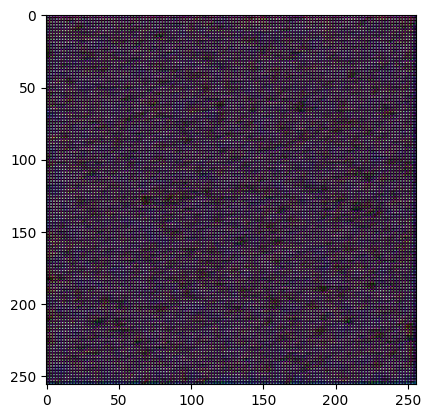

In [74]:
#model = tf.keras.models.load_model('./results/result2')
ds3 = tf.data.Dataset.from_tensor_slices((np.array([1]),np.array([1]))).map(create_dataset).batch(1)
modeltest = model.predict(ds3)
mintest = np.min(modeltest)
maxtest = np.max(modeltest)
modeltest = (modeltest-mintest)/(maxtest-mintest)
plt.imshow(modeltest.reshape((256,256,3)))

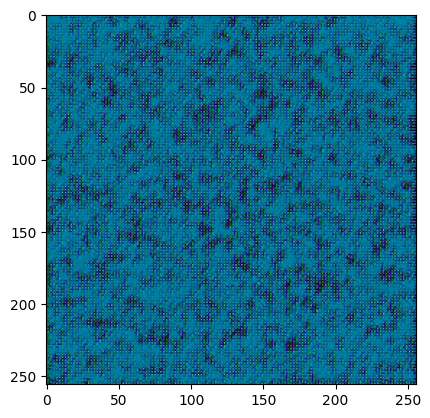

In [75]:
model = tf.keras.models.load_model('./results/result2')
ds3 = tf.data.Dataset.from_tensor_slices((np.array([1]),np.array([1]))).map(create_dataset).batch(1)
modeltest = model.predict(ds3)
mintest = np.min(modeltest)
maxtest = np.max(modeltest)
modeltest = (modeltest-mintest)/(maxtest-mintest)
plt.imshow(modeltest.reshape((256,256,3)))

<span style="color:red; font-size:20pt; font-family:Times New Roman">
The generated results can be seen to be not very satisfactory, and I believe the main reason is the insufficient number of training epochs. I tested the results with only 10 epochs of training, and could only see sporadic black dots. After training for 30 epochs, the number of generated black dots noticeably increased. I believe that with the continuous increase in the number of training epochs, the quality of generated results will also be improved. This notebook was trained on an RTX 4090 for the sole purpose of understanding the structure of the Stable Diffusion model. Even with reduced data volume and training iterations, such large models are not feasible for training on a personal computer.<br>
可以看到生成的结果并不是十分理想，我认为主要原因是训练的epoch数不足。我测试了只训练10个epoch的结果，仅能看到零星的几个黑点，训练30个epoch后生成的黑点数量明显增加。想来随着训练epoch数的不断增加，生成的效果也会得到提升。本notebook是在一张RTX 4090上进行的训练，仅为了解Stable Diffusion模型结构之用，即使减少了数据量和训练代数，这类大模型也不是personal computer可以训练的